In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils import check_array
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import Dense,LSTM,Dropout,Activation
import os
from sklearn.metrics import mean_absolute_percentage_error
from pandas import DataFrame

In [2]:
df=pd.read_csv('Delta_deaths.csv')
df.head()

death
0  12721
1  24136
2  35445
3  44987
4  56159

In [3]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 

In [4]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_4100/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_4100/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [5]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [23]:
n_past = 5
n_future =7
n_features = 1

In [24]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [25]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [99]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_32 (LSTM)                 [(None, 5, 100),     40800       ['input_9[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_33 (LSTM)                 [(None, 100),        80400       ['lstm_32[0][0]']                
                                 (None, 100),                                               

In [100]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split = 0.2,batch_size=16,verbose=0)

In [47]:
model=load_model("LSTM_3days.h5")
#model=model.save("LSTM_3days.h5")

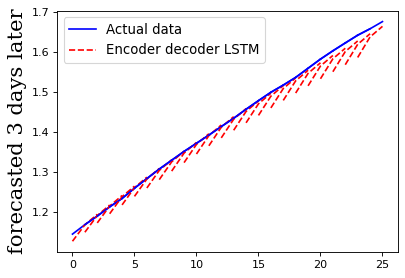

In [48]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    


In [49]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.03188957552331375
Day  2 :
MAE-E2D2 :  0.007681004492927727
Day  3 :
MAE-E2D2 :  0.005228303211361122


mean 0.01493296107586753


In [50]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  2.2157745026967244
Day  2 :
MAE-E2D2 :  0.5013047319517423
Day  3 :
MAE-E2D2 :  0.34993763487523627


mean 1.022338956507901


In [51]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



death
Day  1 :
MAE-E2D2 :  0.03407939179796601
Day  2 :
MAE-E2D2 :  0.01052877546655032
Day  3 :
MAE-E2D2 :  0.006807987790098058


mean 0.01713871835153813


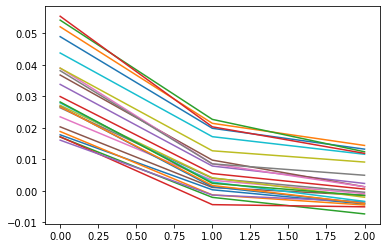

In [52]:
#residual plot

residuals = y_test-pred3LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

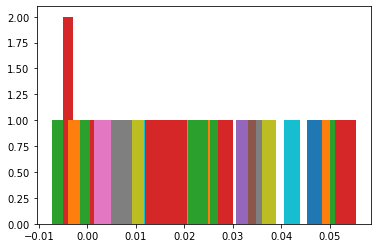

In [53]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

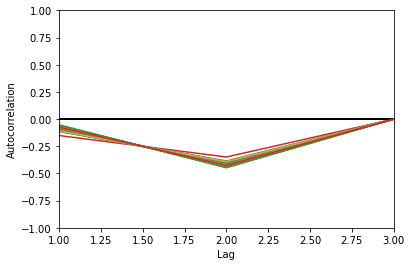

In [54]:
from pandas.plotting import autocorrelation_plot
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [17]:
model=load_model("LSTM_5days.h5")
#model=model.save("LSTM_5days.h5")

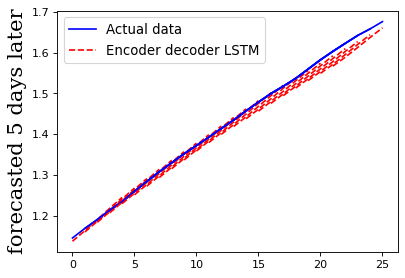

In [18]:
pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"red",linestyle='dashed')
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    #plt.xlabel("days")   
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
#plt.legend()

In [19]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.01657336787476232
Day  2 :
MAE-E2D2 :  0.014073301063207195
Day  3 :
MAE-E2D2 :  0.009885666508304166
Day  4 :
MAE-E2D2 :  0.006846935730113544
Day  5 :
MAE-E2D2 :  0.0073123496404863065


mean 0.010938324163374705


In [20]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  1.1565098806888434
Day  2 :
MAE-E2D2 :  0.9566760183425272
Day  3 :
MAE-E2D2 :  0.647540997247729
Day  4 :
MAE-E2D2 :  0.44655206846713646
Day  5 :
MAE-E2D2 :  0.4951166029695028


mean 0.7404791135431478


In [62]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


death
Day  1 :
MAE-E2D2 :  0.018635467849196414
Day  2 :
MAE-E2D2 :  0.01667739005665476
Day  3 :
MAE-E2D2 :  0.013267420973934262
Day  4 :
MAE-E2D2 :  0.009882249959196607
Day  5 :
MAE-E2D2 :  0.008371901608352713


mean 0.013366886089466951


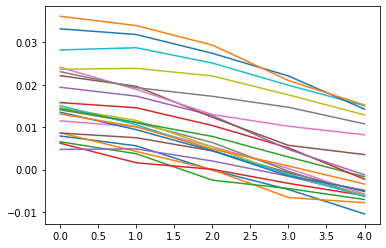

In [21]:
#residual plot

residuals = y_test-pred5LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

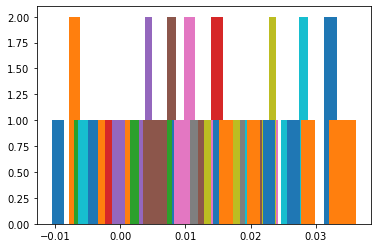

In [64]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

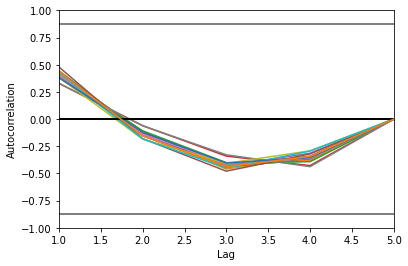

In [65]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

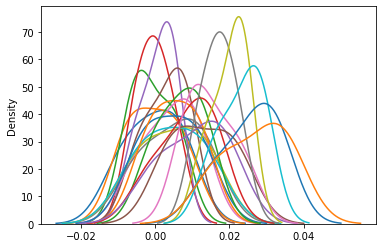

In [22]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [26]:
model=load_model("LSTM_7days.h5")
#model=model.save("LSTM_7days.h5")

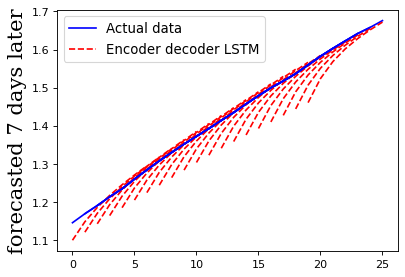

In [27]:
pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)


In [28]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.06895886475081296
Day  2 :
MAE-E2D2 :  0.03479208835576484
Day  3 :
MAE-E2D2 :  0.015115138097588687
Day  4 :
MAE-E2D2 :  0.005536023253262435
Day  5 :
MAE-E2D2 :  0.006508525928100384
Day  6 :
MAE-E2D2 :  0.008056295111816537
Day  7 :
MAE-E2D2 :  0.008582875583041116


mean 0.02107854444005528


In [109]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  5.012840364063618
Day  2 :
MAE-E2D2 :  2.471462602908802
Day  3 :
MAE-E2D2 :  1.0365511028961338
Day  4 :
MAE-E2D2 :  0.3667854238405708
Day  5 :
MAE-E2D2 :  0.45458429427576286
Day  6 :
MAE-E2D2 :  0.5643126731784974
Day  7 :
MAE-E2D2 :  0.5981883905555174


mean 1.500674978816986


In [110]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


death
Day  1 :
MAE-E2D2 :  0.07085002472219894
Day  2 :
MAE-E2D2 :  0.03654235856737726
Day  3 :
MAE-E2D2 :  0.017344705065419304
Day  4 :
MAE-E2D2 :  0.008267068718768724
Day  5 :
MAE-E2D2 :  0.007124093434256496
Day  6 :
MAE-E2D2 :  0.008469079499874
Day  7 :
MAE-E2D2 :  0.009529453704729355


mean 0.022589540530374867


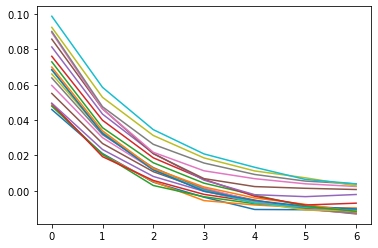

In [111]:
#residual plot

residuals = y_test-pred7LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

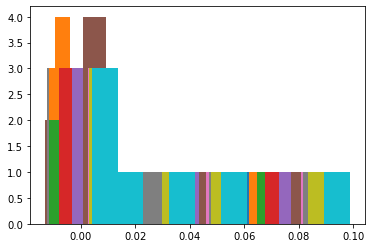

In [112]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

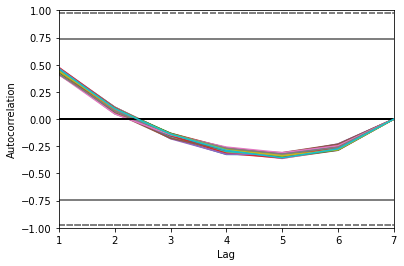

In [113]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

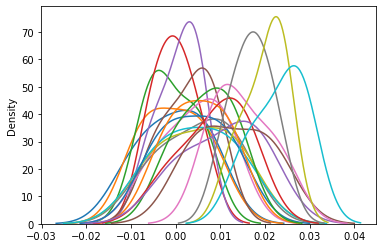

In [29]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [ ]:
#BiLSTM

In [6]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_4100/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_4100/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [7]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [8]:
n_past = 5
n_future =3
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [9]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [304]:
#define model
model = Sequential()
model.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(n_past, n_features)))
model.add(Bidirectional(LSTM(128,activation='relu')))
model.add(Dense(128))
model.add(Dense(n_future))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [305]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 16)

Epoch 1/100
4/4 [==============================] - 10s 786ms/step - loss: 0.1462 - val_loss: 0.4746
Epoch 2/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0797 - val_loss: 0.3081
Epoch 3/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0300 - val_loss: 0.0687
Epoch 4/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0089 - val_loss: 0.0408
Epoch 5/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0126 - val_loss: 0.0111
Epoch 6/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0043 - val_loss: 0.0180
Epoch 7/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0039 - val_loss: 0.0389
Epoch 8/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0033 - val_loss: 0.0335
Epoch 9/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 10/100
4/4 [==============================] - 0s 73ms/step - loss: 8.9916e-04 - val_loss: 0.0038
Epoch 11/100


In [11]:
#model.save('bilstm_3days.h5')
model=load_model("bilstm_3days.h5")

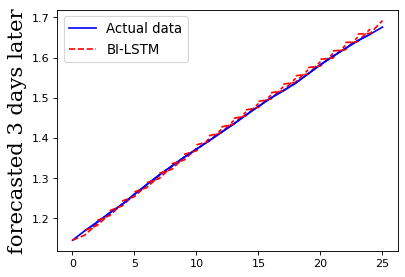

In [12]:
pred3BiLSTM=model.predict(X_test)
pred3BiLSTM = pred3BiLSTM.reshape((pred3BiLSTM.shape[0], pred3BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
font1 = {'family':'Serif','color':'black','size':19}

figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later",fontdict = font1)
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [120]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.010201451177008528
Day  2 :
MAE-E2D2 :  0.0040620266783829755
Day  3 :
MAE-E2D2 :  0.006328971116524955


mean 0.006864149657305487


In [121]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  0.6998707690893127
Day  2 :
MAE-E2D2 :  0.3053107476086046
Day  3 :
MAE-E2D2 :  0.4178421676733378


mean 0.4743412281237516


In [122]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.01142555929327693
Day  2 :
MAE-E2D2 :  0.005032608033691788
Day  3 :
MAE-E2D2 :  0.007593486923363737


mean 0.008017218083444152


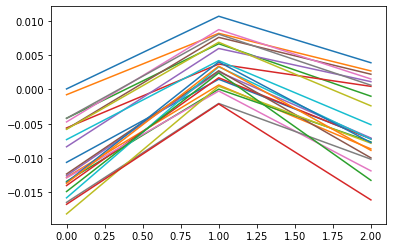

In [36]:
#residual plot

residuals = y_test-pred3BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

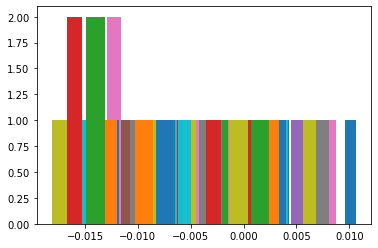

In [124]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

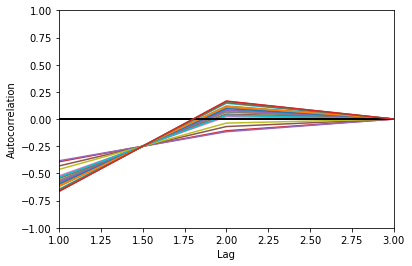

In [125]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)   

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

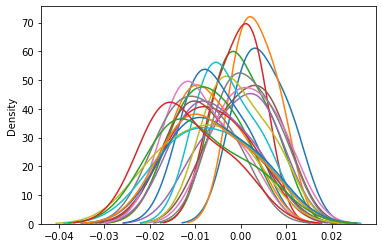

In [37]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [128]:
#model.save('bilstm_5days.h5')
model=load_model("bilstm_5days.h5")

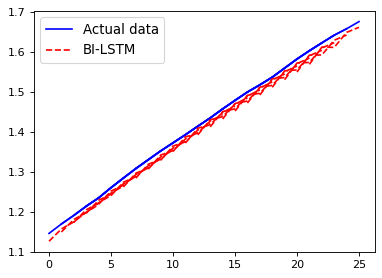

In [129]:
pred5BiLSTM=model.predict(X_test)
pred5BiLSTM= pred5BiLSTM.reshape((pred5BiLSTM.shape[0], pred5BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [130]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.023413260955733775
Day  2 :
MAE-E2D2 :  0.008342661258713897
Day  3 :
MAE-E2D2 :  0.020845474049504705
Day  4 :
MAE-E2D2 :  0.011439316312428166
Day  5 :
MAE-E2D2 :  0.016690107850856218


mean 0.016146164085447355


In [131]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  1.687007294344396
Day  2 :
MAE-E2D2 :  0.6071208599153916
Day  3 :
MAE-E2D2 :  1.4531311776594065
Day  4 :
MAE-E2D2 :  0.8093193873514916
Day  5 :
MAE-E2D2 :  1.1564826659711074


mean 1.1426122770483587


In [132]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.023839889971011136
Day  2 :
MAE-E2D2 :  0.00870223641702053
Day  3 :
MAE-E2D2 :  0.021358924861522355
Day  4 :
MAE-E2D2 :  0.01174082432377041
Day  5 :
MAE-E2D2 :  0.016869355209584814


mean 0.01650224615658185


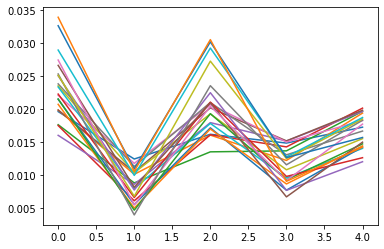

In [133]:
#residual plot

residuals = y_test-pred5BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

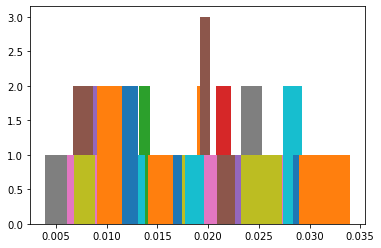

In [134]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

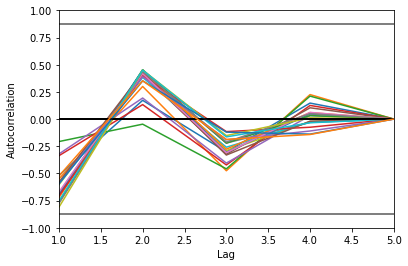

In [135]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [138]:
#model.save('bilstm_7days.h5')
model=load_model("bilstm_7days.h5")

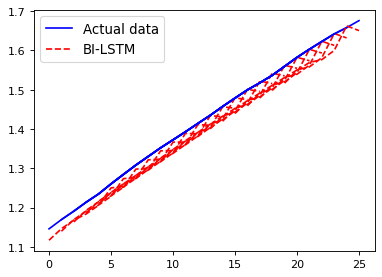

In [139]:
pred7BiLSTM=model.predict(X_test)
pred7BiLSTM = pred7BiLSTM.reshape((pred7BiLSTM.shape[0], pred7BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [140]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  0.033788112940739114
Day  2 :
MAE-E2D2 :  0.02489251979802558
Day  3 :
MAE-E2D2 :  0.025470002694909243
Day  4 :
MAE-E2D2 :  0.035432659606741156
Day  5 :
MAE-E2D2 :  0.03417891788110763
Day  6 :
MAE-E2D2 :  0.004130404786145525
Day  7 :
MAE-E2D2 :  0.026778812271148512


mean 0.02638163285411668


In [141]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  2.4817769281642432
Day  2 :
MAE-E2D2 :  1.8029704588592124
Day  3 :
MAE-E2D2 :  1.8180404525738918
Day  4 :
MAE-E2D2 :  2.485225695205954
Day  5 :
MAE-E2D2 :  2.369227001259035
Day  6 :
MAE-E2D2 :  0.30007440518980627
Day  7 :
MAE-E2D2 :  1.8191817531741046


mean 1.8680709563466067


In [142]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    



death
Day  1 :
MAE-E2D2 :  0.034096542577537484
Day  2 :
MAE-E2D2 :  0.025109072788422206
Day  3 :
MAE-E2D2 :  0.02566670908161829
Day  4 :
MAE-E2D2 :  0.03573264905333825
Day  5 :
MAE-E2D2 :  0.034359656974994185
Day  6 :
MAE-E2D2 :  0.005461237251278054
Day  7 :
MAE-E2D2 :  0.02690579508183776


mean 0.026761666115575178


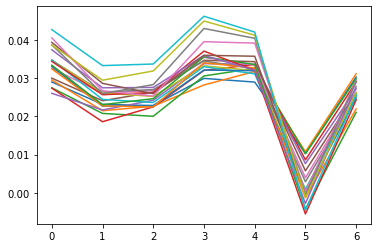

In [143]:
#residual plot

residuals = y_test-pred7BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

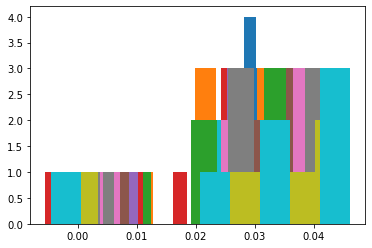

In [144]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

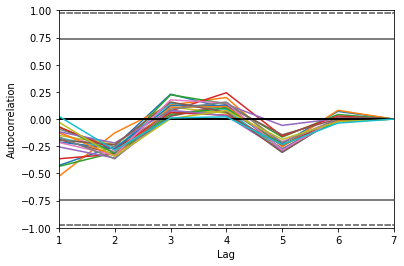

In [145]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#ConvLSTM

In [12]:
n_past=4
n_future=7
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):]
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
    
    
    
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y) 


X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

n_features = 1
n_seq = 2
n_steps = 2
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_8220/427068468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_8220/427068468.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [375]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

In [376]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False)

Epoch 1/100
5/5 [==============================] - 6s 143ms/step - loss: 0.1702 - val_loss: 0.5681
Epoch 2/100
5/5 [==============================] - 0s 27ms/step - loss: 0.1630 - val_loss: 0.5609
Epoch 3/100
5/5 [==============================] - 0s 28ms/step - loss: 0.1576 - val_loss: 0.5529
Epoch 4/100
5/5 [==============================] - 0s 29ms/step - loss: 0.1526 - val_loss: 0.5446
Epoch 5/100
5/5 [==============================] - 0s 28ms/step - loss: 0.1478 - val_loss: 0.5362
Epoch 6/100
5/5 [==============================] - 0s 26ms/step - loss: 0.1430 - val_loss: 0.5274
Epoch 7/100
5/5 [==============================] - 0s 25ms/step - loss: 0.1381 - val_loss: 0.5180
Epoch 8/100
5/5 [==============================] - 0s 27ms/step - loss: 0.1330 - val_loss: 0.5078
Epoch 9/100
5/5 [==============================] - 0s 23ms/step - loss: 0.1278 - val_loss: 0.4967
Epoch 10/100
5/5 [==============================] - 0s 23ms/step - loss: 0.1222 - val_loss: 0.4847
Epoch 11/100
5/5 [

In [147]:
#model.save('ConvLSTM_3days.h5')
model=load_model("ConvLSTM_3days.h5")

In [148]:
pred3ConvLSTM=model.predict(X_test)

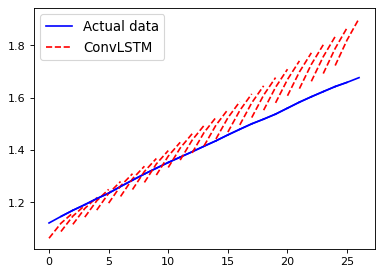

In [149]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [150]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3ConvLSTM = pred3ConvLSTM.reshape((pred3ConvLSTM.shape[0], pred3ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.03635380688276243
Day  2 :
MAE-E2D2 :  0.06079951547359388
Day  3 :
MAE-E2D2 :  0.09366524455445063


mean 0.06360618897026898


In [151]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

death
Day  1 :
MAE-E2D2 :  2.656412271872593
Day  2 :
MAE-E2D2 :  4.00892316417093
Day  3 :
MAE-E2D2 :  6.112357188139416


mean 4.259230874727646


In [152]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    




death
Day  1 :
MAE-E2D2 :  0.041817481439743065
Day  2 :
MAE-E2D2 :  0.0780622240703157
Day  3 :
MAE-E2D2 :  0.11568219914832545


mean 0.07852063488612808


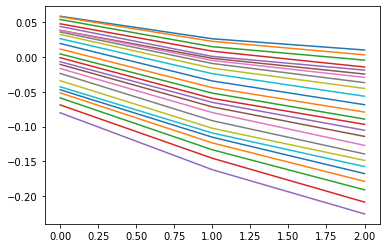

In [153]:
#residual plot

residuals = y_test-pred3ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

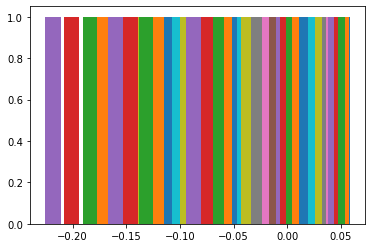

In [154]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

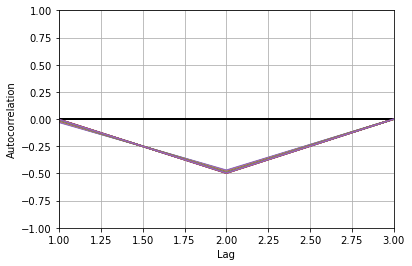

In [155]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [7]:
#model.save('ConvLSTM_5days.h5')
model=load_model("ConvLSTM_5days.h5")

In [8]:
pred5ConvLSTM=model.predict(X_test)

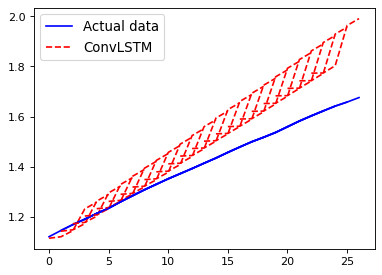

In [9]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [10]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5ConvLSTM = pred5ConvLSTM.reshape((pred5ConvLSTM.shape[0], pred5ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.07478119496262246
Day  2 :
MAE-E2D2 :  0.06044650312592246
Day  3 :
MAE-E2D2 :  0.06482431560518954
Day  4 :
MAE-E2D2 :  0.16161591888751203
Day  5 :
MAE-E2D2 :  0.1680428743470141


mean 0.10594216138565211


In [11]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  5.115184553678477
Day  2 :
MAE-E2D2 :  4.064310244503122
Day  3 :
MAE-E2D2 :  4.294376509154794
Day  4 :
MAE-E2D2 :  10.839055702406599
Day  5 :
MAE-E2D2 :  11.125863836283472


mean 7.0877581692052924


In [162]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.0920194902143024
Day  2 :
MAE-E2D2 :  0.07705195643478209
Day  3 :
MAE-E2D2 :  0.08247618423663458
Day  4 :
MAE-E2D2 :  0.18030661492890857
Day  5 :
MAE-E2D2 :  0.18677599139685283


mean 0.1237260474422961


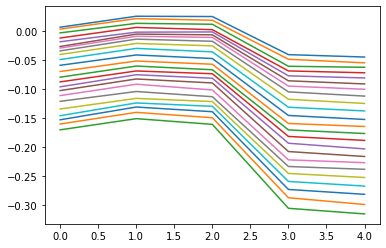

In [163]:
#residual plot

residuals = y_test-pred5ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

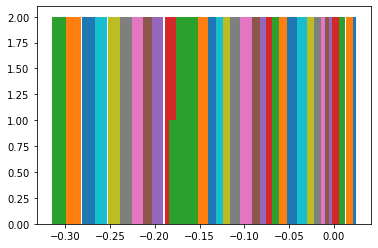

In [164]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

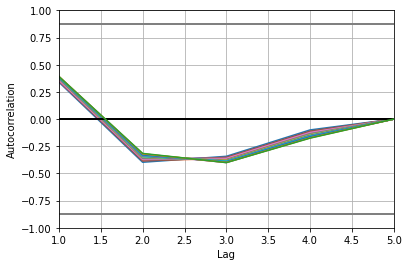

In [165]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [13]:
#model.save('ConvLSTM_7days.h5')
model=load_model("ConvLSTM_7days.h5")

In [14]:
pred7ConvLSTM=model.predict(X_test)

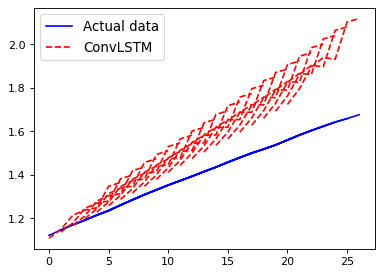

In [15]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [17]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7ConvLSTM = pred7ConvLSTM.reshape((pred7ConvLSTM.shape[0], pred7ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

death
Day  1 :
MAE-E2D2 :  0.06800831335673274
Day  2 :
MAE-E2D2 :  0.09918351517384416
Day  3 :
MAE-E2D2 :  0.1598628775288526
Day  4 :
MAE-E2D2 :  0.17103247655585618
Day  5 :
MAE-E2D2 :  0.15143290878449384
Day  6 :
MAE-E2D2 :  0.26490930103885746
Day  7 :
MAE-E2D2 :  0.26036334028284824


mean 0.16782753324592647


In [18]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

death
Day  1 :
MAE-E2D2 :  4.733539815286525
Day  2 :
MAE-E2D2 :  6.858944463423892
Day  3 :
MAE-E2D2 :  11.084692503642454
Day  4 :
MAE-E2D2 :  11.674530007180703
Day  5 :
MAE-E2D2 :  10.15673642690484
Day  6 :
MAE-E2D2 :  17.73883630770827
Day  7 :
MAE-E2D2 :  17.179345320782183


mean 11.346660692132698


In [19]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


death
Day  1 :
MAE-E2D2 :  0.08521168610872024
Day  2 :
MAE-E2D2 :  0.11845724066172497
Day  3 :
MAE-E2D2 :  0.17704798762373564
Day  4 :
MAE-E2D2 :  0.1901073539939476
Day  5 :
MAE-E2D2 :  0.17056671093351863
Day  6 :
MAE-E2D2 :  0.2837695838505322
Day  7 :
MAE-E2D2 :  0.27986994822188793


mean 0.18643293019915244


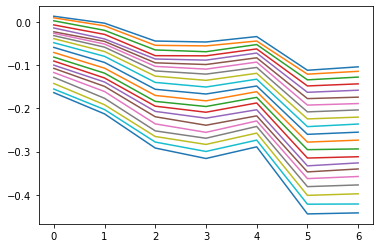

In [173]:
#residual plot

residuals = y_test-pred7ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

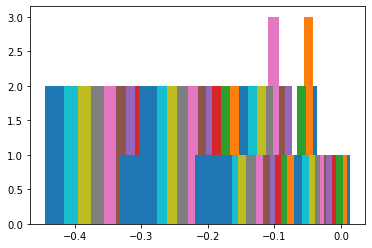

In [174]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

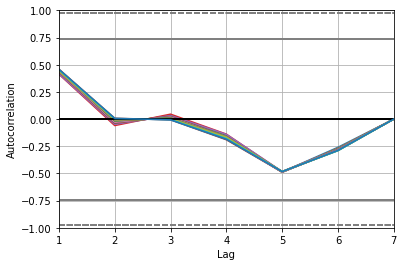

In [175]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#GRU

In [20]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_8220/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_8220/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [21]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [37]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [38]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

In [215]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (85, 5, 1)
y_train.shape:  (85, 3)
X_test.shape:  (24, 5, 1)
y_test.shape:  (24, 3)


In [402]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = n_future)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [403]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        )
    return history
history_gru = fit_model(model_gru)


Epoch 1/100
4/4 [==============================] - 7s 429ms/step - loss: 0.1565 - val_loss: 0.5170
Epoch 2/100
4/4 [==============================] - 0s 26ms/step - loss: 0.1232 - val_loss: 0.4655
Epoch 3/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0998 - val_loss: 0.4085
Epoch 4/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0756 - val_loss: 0.3445
Epoch 5/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0578 - val_loss: 0.2729
Epoch 6/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0416 - val_loss: 0.1970
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0281 - val_loss: 0.1271
Epoch 8/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0196 - val_loss: 0.0723
Epoch 9/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0137 - val_loss: 0.0383
Epoch 10/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0093 - val_loss: 0.0187
Epoch 11/100
4/4 [

In [24]:
#model_gru.save('GRU_3days.h5')
model_gru=load_model("GRU_3days.h5")

In [25]:
pred3GRU=model_gru.predict(X_test)

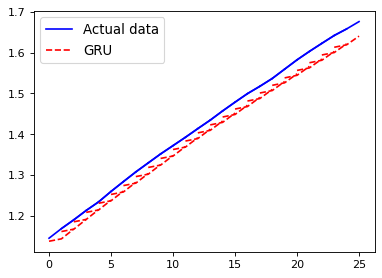

In [26]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [27]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3GRU = pred3GRU.reshape((pred3GRU.shape[0], pred3GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.013918437363879746
Day  2 :
MAE-E2D2 :  0.029230126639368876
Day  3 :
MAE-E2D2 :  0.027522659987869125


mean 0.023557074663705917


In [28]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


death
Day  1 :
MAE-E2D2 :  0.952926347595696
Day  2 :
MAE-E2D2 :  2.038643091285132
Day  3 :
MAE-E2D2 :  1.8923430950682136


mean 1.6279708446496806


In [29]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.01584108331222808
Day  2 :
MAE-E2D2 :  0.02991246614544638
Day  3 :
MAE-E2D2 :  0.02814085876619485


mean 0.024631469407956436


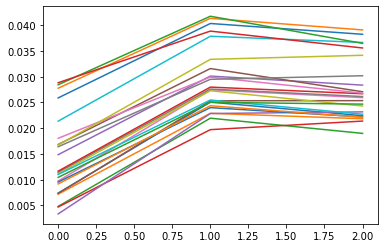

In [187]:
#residual plot

residuals = y_test-pred3GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

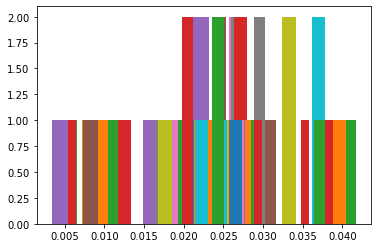

In [188]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

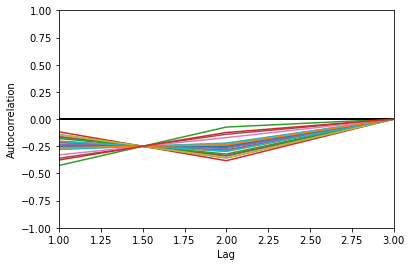

In [189]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [32]:
#model_gru.save('GRU_5days.h5')
model_gru=load_model("GRU_5days.h5")

In [33]:
pred5GRU=model_gru.predict(X_test)


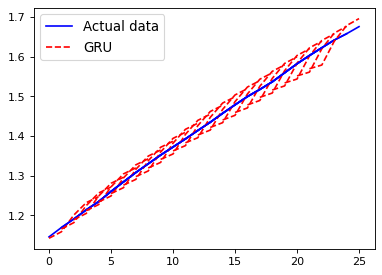

In [34]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [35]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5GRU = pred5GRU.reshape((pred5GRU.shape[0], pred5GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.013109378920391646
Day  2 :
MAE-E2D2 :  0.02181740744262947
Day  3 :
MAE-E2D2 :  0.008155510125043937
Day  4 :
MAE-E2D2 :  0.022046535192157792
Day  5 :
MAE-E2D2 :  0.016967703053906744


mean 0.016419306946825918


In [36]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


death
Day  1 :
MAE-E2D2 :  0.8980646024323656
Day  2 :
MAE-E2D2 :  1.5040235127487345
Day  3 :
MAE-E2D2 :  0.5963921255114069
Day  4 :
MAE-E2D2 :  1.537972018580023
Day  5 :
MAE-E2D2 :  1.1523165562564002


mean 1.1377537631057861


In [198]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.015933531141972834
Day  2 :
MAE-E2D2 :  0.02414425780309616
Day  3 :
MAE-E2D2 :  0.00888906037005349
Day  4 :
MAE-E2D2 :  0.02224244843879253
Day  5 :
MAE-E2D2 :  0.01733803056162808


mean 0.01770946566310862


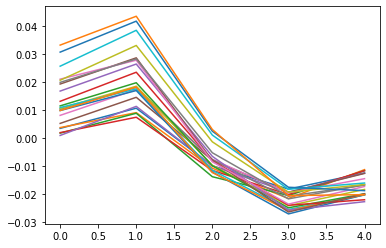

In [199]:
#residual plot

residuals = y_test-pred5GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

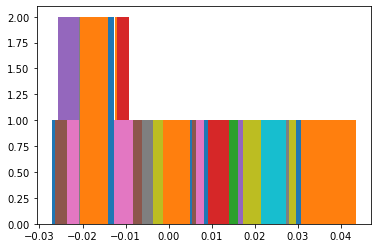

In [200]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

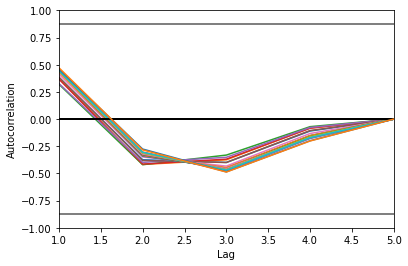

In [201]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [39]:
#model_gru.save('GRU_7days.h5')
model_gru=load_model("GRU_7days.h5")

In [40]:
pred7GRU=model_gru.predict(X_test)


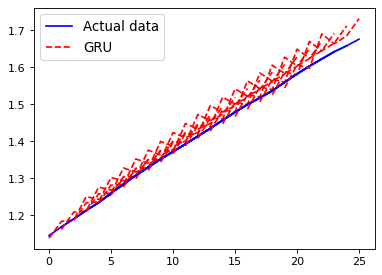

In [41]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7days later") 
    plt.legend(['Actual data','GRU'],fontsize=12)

In [42]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7GRU = pred7GRU.reshape((pred7GRU.shape[0], pred7GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

death
Day  1 :
MAE-E2D2 :  0.007803909125278907
Day  2 :
MAE-E2D2 :  0.02449184766794732
Day  3 :
MAE-E2D2 :  0.0023401051477205835
Day  4 :
MAE-E2D2 :  0.056260610599710256
Day  5 :
MAE-E2D2 :  0.017937106613063514
Day  6 :
MAE-E2D2 :  0.014252356813240418
Day  7 :
MAE-E2D2 :  0.03897706760784929


mean 0.023151857653544328


In [43]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


death
Day  1 :
MAE-E2D2 :  0.5629611890628878
Day  2 :
MAE-E2D2 :  1.7664352417542268
Day  3 :
MAE-E2D2 :  0.16553965644331842
Day  4 :
MAE-E2D2 :  3.921518455089991
Day  5 :
MAE-E2D2 :  1.219056699151746
Day  6 :
MAE-E2D2 :  0.9333745412163028
Day  7 :
MAE-E2D2 :  2.5777389801424437


mean 1.592374966122988


In [209]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



death
Day  1 :
MAE-E2D2 :  0.008475934026793563
Day  2 :
MAE-E2D2 :  0.024862337153695853
Day  3 :
MAE-E2D2 :  0.0027270480577956386
Day  4 :
MAE-E2D2 :  0.057221096911849824
Day  5 :
MAE-E2D2 :  0.018901467043455026
Day  6 :
MAE-E2D2 :  0.016581659147068457
Day  7 :
MAE-E2D2 :  0.0406685435240881


mean 0.024205440837820925


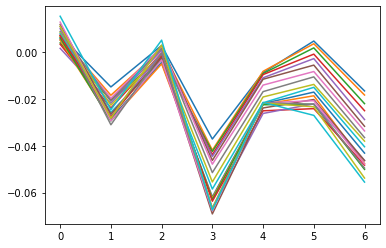

In [210]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

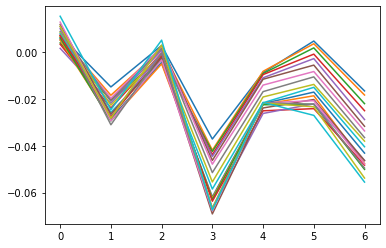

In [211]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

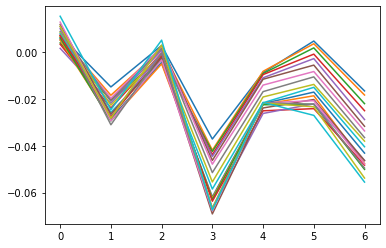

In [212]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

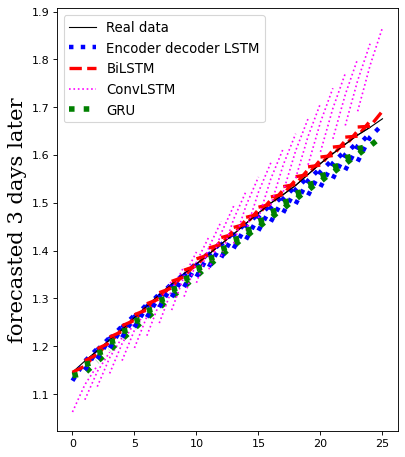

In [216]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black",linewidth=1)
    plt.plot(range(i,i+n_future),pred3LSTM[i],"blue",linestyle='dotted',linewidth=4)
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed',linewidth=3)
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"magenta",linestyle='dotted')
    plt.plot(range(i,i+n_future),pred3GRU[i],"green",linestyle='dotted',linewidth=5)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

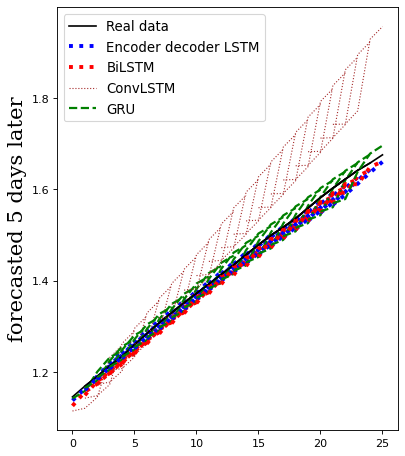

In [101]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"blue",linestyle='dotted',linewidth=3.5)
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dotted',linewidth=3.5)
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"brown",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred5GRU[i],"green",linestyle='dashed',linewidth=2)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

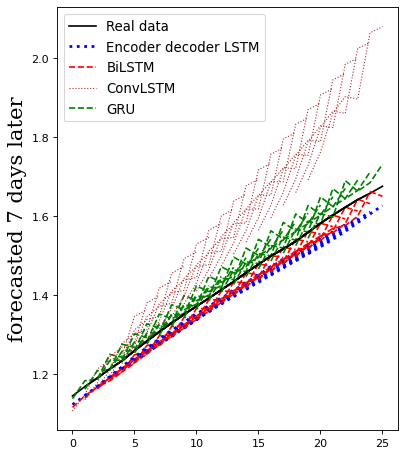

In [89]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"blue",linestyle='dotted',linewidth=2.5)
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"brown",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred7GRU[i],"green",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()